# Yelp Restaurant Recommender System - Part 2: EDA and Modeling

- The notebook was constructed and ran on Google Colab+ in order to execute large datasets. 
- In order to obtain the original dataset, please download from yelp open dataset.

In [1]:
# Imports
! pip install surprise  # Install surprise scikit 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from scipy import sparse
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from surprise import Reader, Dataset, KNNBasic, KNNWithMeans, accuracy, prediction_algorithms
from surprise import SVD, SVDpp, SlopeOne, NMF, CoClustering

from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity


%matplotlib inline

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization to access google drive.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load business dataset
business = pd.read_csv('/content/drive/MyDrive/business.csv')
business = business.loc[(business['is_open']==1)] # Filter out businesses that still open in 2021
business = business.drop(columns=['Unnamed: 0', 'is_open'])
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,business_stars,review_count,RestaurantsGoodForGroups_False,RestaurantsGoodForGroups_True,HasTV_False,HasTV_True,GoodForKids_False,GoodForKids_True,RestaurantsTakeOut_False,RestaurantsTakeOut_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,BikeParking_False,BikeParking_True,RestaurantsReservations_False,RestaurantsReservations_True,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsAttire_u'casual',RestaurantsAttire_u'dressy',RestaurantsAttire_u'formal',RestaurantsDelivery_False,RestaurantsDelivery_True,OutdoorSeating_False,OutdoorSeating_True,NoiseLevel_'average',NoiseLevel_'loud',NoiseLevel_'quiet',NoiseLevel_'very_loud',NoiseLevel_u'average',...,Southern,Spanish,Specialty Food,Specialty Schools,Sports Bars,Steakhouses,Street Vendors,Surf Shop,Sushi Bars,Szechuan,Tabletop Games,Tacos,Taiwanese,Tapas Bars,Tapas/Small Plates,Tea Rooms,Telecommunications,Teppanyaki,Tex-Mex,Thai,Tiki Bars,Tires,Tours,Transportation,Trinidadian,Turkish,Ukrainian,Vegan,Vegetarian,Venezuelan,Venues & Event Spaces,Vietnamese,Waffles,Wedding Planning,Weight Loss Centers,Whiskey Bars,Wine Bars,Wineries,Wraps,Yelp Events
0,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,1960,42.541155,-70.973438,4.0,39,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,hcRxdDg7DYryCxCoI8ySQA,Longwood Galleria,340-350 Longwood Ave,Boston,MA,2215,42.338544,-71.106842,2.5,24,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,1 Harborside Dr,Boston,MA,2128,42.363442,-71.025781,3.5,856,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,buTr0hMiyDbjQvFJgm-Eew,JP Licks,611 Assembly Row,Somerville,MA,2145,42.395406,-71.079491,3.5,131,0,1,1,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3ME_CSB1bo4F0QMhQRUeOA,Yan's China Bistro,146 Humphrey St,Swampscott,MA,1907,42.468081,-70.916752,4.0,74,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Some of the longitude values for MA are not negative, believed to be recording error
business['longitude'].sort_values(ascending=False)
business['longitude'] = [-abs(row) for row in business['longitude']]

In [5]:
# Load reviews dataset
reviews = pd.read_csv('/content/drive/MyDrive/reviews.csv')
reviews = reviews.drop(columns=['Unnamed: 0'])
reviews.head()

,user_id,business_id,review_stars,date
0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,2014-10-11 03:34:02
1,RNm_RWkcd02Li2mKPRe7Eg,xGXzsc-hzam-VArK6eTvtw,1.0,2018-01-21 04:41:03
2,Q8c91v7luItVB0cMFF_mRA,EXOsmAB1s71WePlQk0WZrA,2.0,2006-04-16 02:58:44
3,99RsBrARhhx60UnAC4yDoA,EEHhKSxUvJkoPSzeGKkpVg,5.0,2014-05-07 18:10:21
4,DECuRZwkUw8ELQZfNGef2Q,zmZ3HkVCeZPBefJJxzdJ7A,4.0,2012-12-04 04:29:47


In [6]:
# Drop columns irrelevant to modeling
bus = business[['business_id', 'name', 'business_stars', 'review_count']]
rev = reviews[['user_id', 'business_id', 'review_stars']]
# Create mergeg dataset on shared business_ids
df = bus.merge(rev, 'inner', on='business_id') # Use bus 
# Save and export merged dataset 
df.to_csv('/content/drive/MyDrive/capstone/merge_df.csv', index=False )
df.shape

(1022275, 6)

# EDA - Explainatory Data Analysis

In [7]:
# Total businesses in the dataset
len(df['business_id'].unique())

6416

In [8]:
# Total users in the dataset
len(df['user_id'].unique())

329072

In [9]:
# Convert the 'date' column to datetime format, for time_series plot
date_list = []
for rows in reviews['date']: 
  date_list.append(rows[:7])

reviews_all = reviews.join(pd.DataFrame(date_list))
reviews_all['date'] = pd.to_datetime(reviews_all[0])
reviews_all = reviews_all.set_index('date')
reviews_all.min(), reviews_all.max() # Find the timespan of the dataset

(user_id         ---7FS-3SMy-cnnIPHcW9w
 business_id     -00d-Qb0q2TcWn-8LBHDZg
 review_stars                       1.0
 0                              2004-10
 dtype: object, user_id         zzzl5-rnSu3jclcANGsLgg
 business_id     zzcdycb7S42VnnZkwE4yNA
 review_stars                       5.0
 0                              2021-01
 dtype: object)

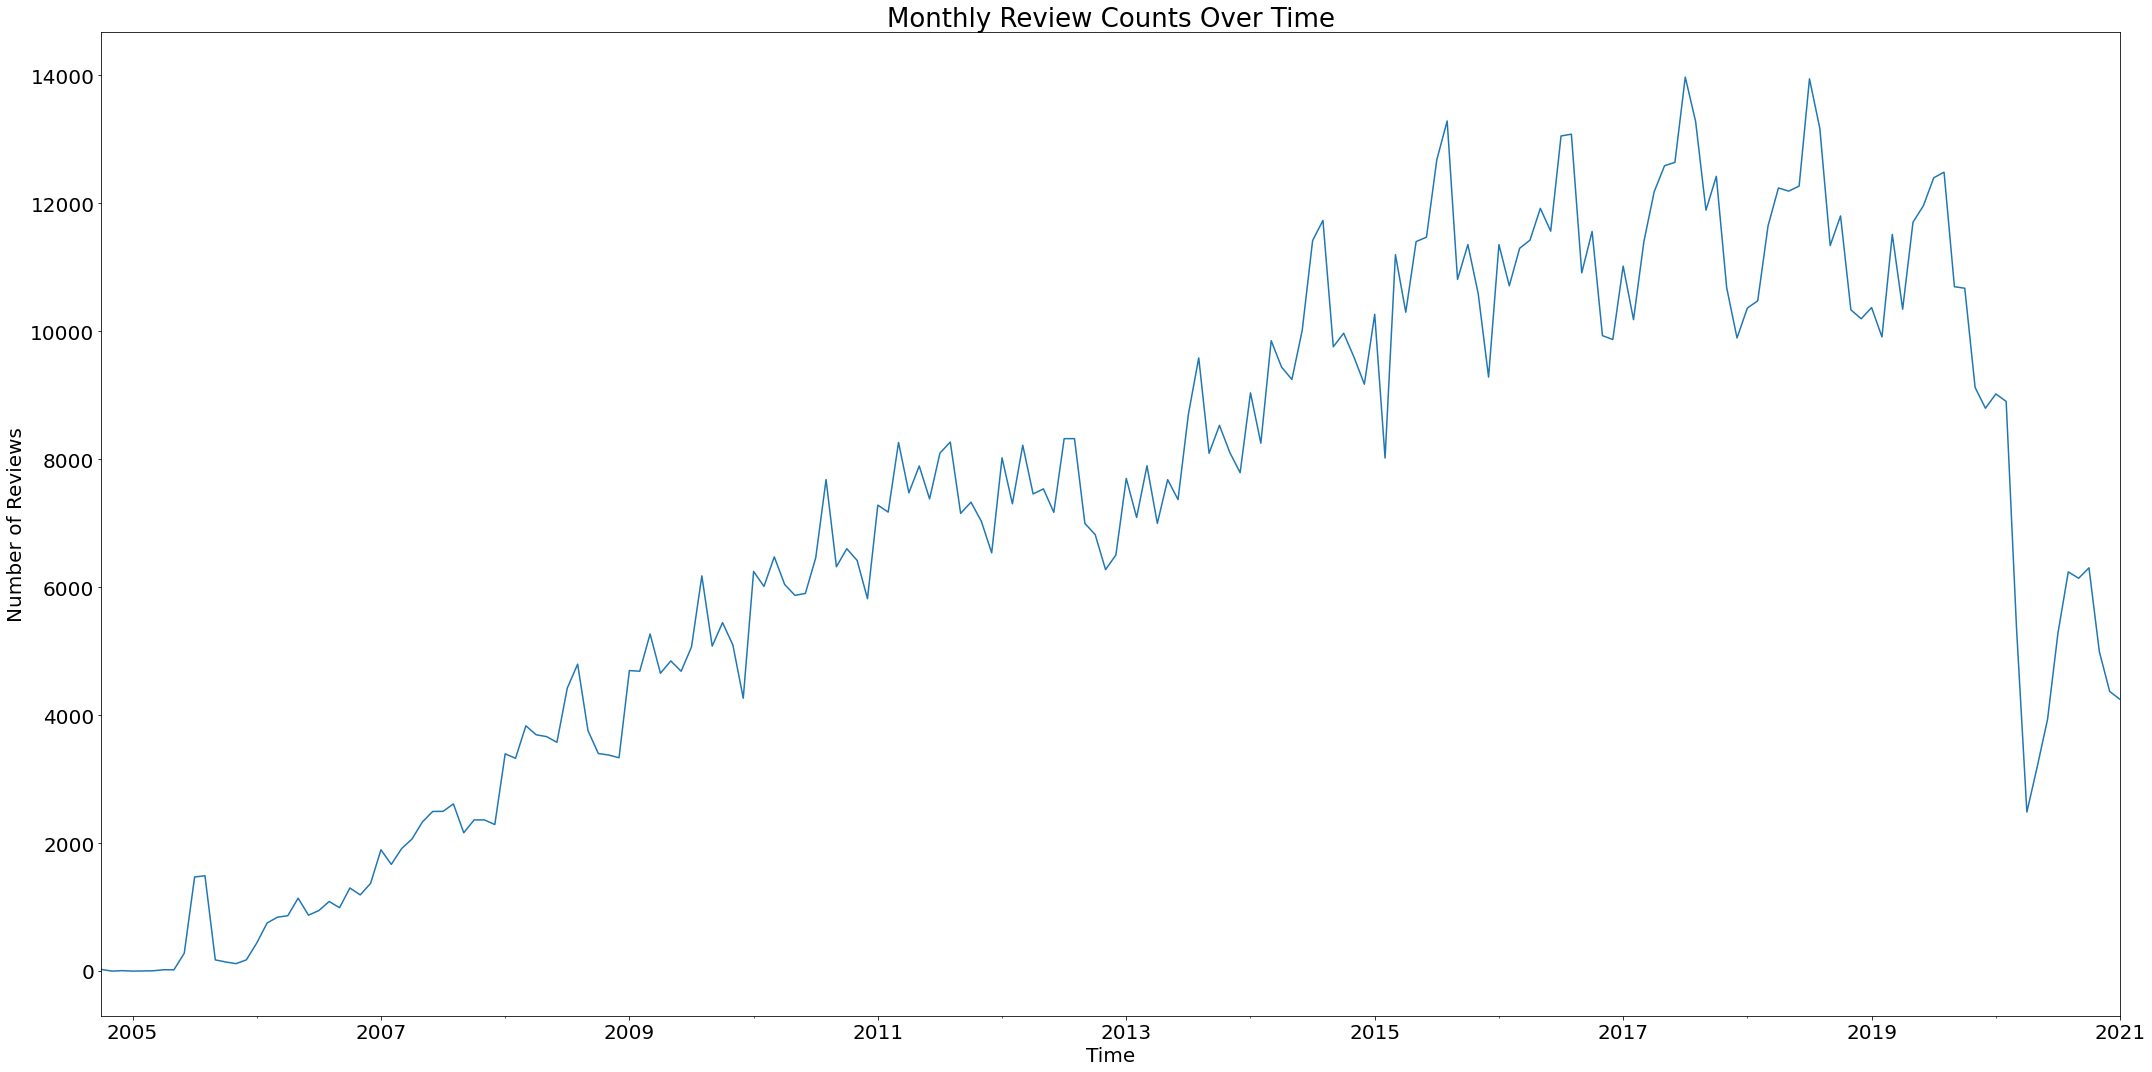

In [10]:
# Number of new reviews over time
plt.figure(figsize=(30,15))
reviews_all.groupby(by='date').count()['user_id'].plot()
plt.title('Monthly Review Counts Over Time', fontsize=26)
plt.xlabel('Time', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Number of Reviews', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/time_series.png')

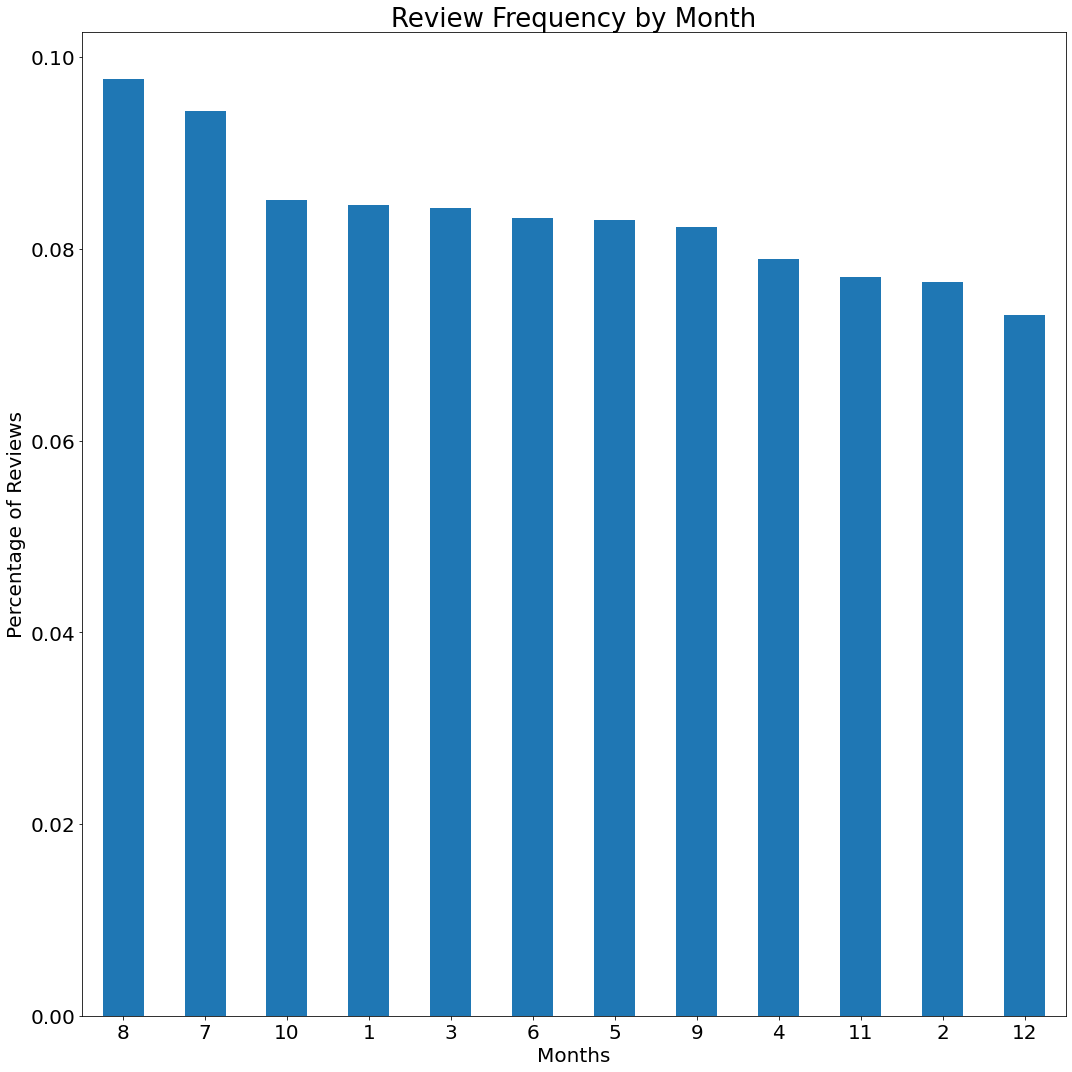

In [11]:
# Review trend over months
plt.figure(figsize=(15,15))
reviews_months = reviews['date'].copy()
reviews_months['date'] = pd.to_datetime(reviews['date']).dt.month
reviews_months['date'].value_counts(normalize=True).plot(kind='bar')
plt.title('Review Frequency by Month', fontsize=26)
plt.xlabel('Months', fontsize=20)
plt.xticks(fontsize=20, rotation='horizontal')
plt.ylabel('Percentage of Reviews', fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/dist_by_month.png')

<Figure size 1440x1440 with 0 Axes>

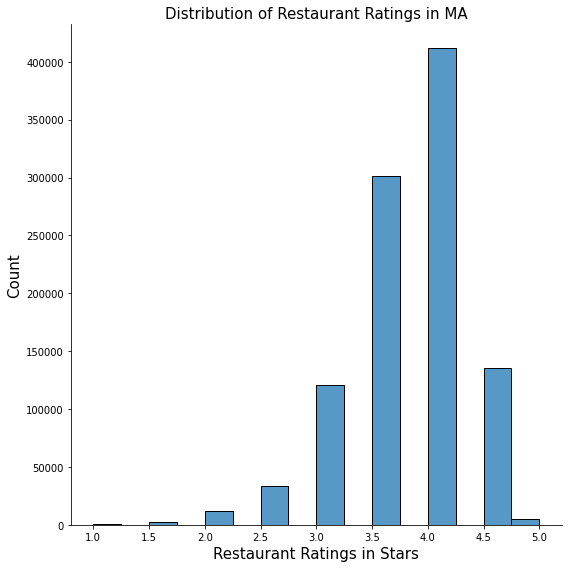

In [12]:
# Distribution of business ratings in MA
plt.figure(figsize=(20,20))
sns.displot(df['business_stars'], height = 8, binwidth=0.25)
plt.title('Distribution of Restaurant Ratings in MA', fontsize = 15)
plt.xlabel('Restaurant Ratings in Stars', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/business_ratings_displot.png');

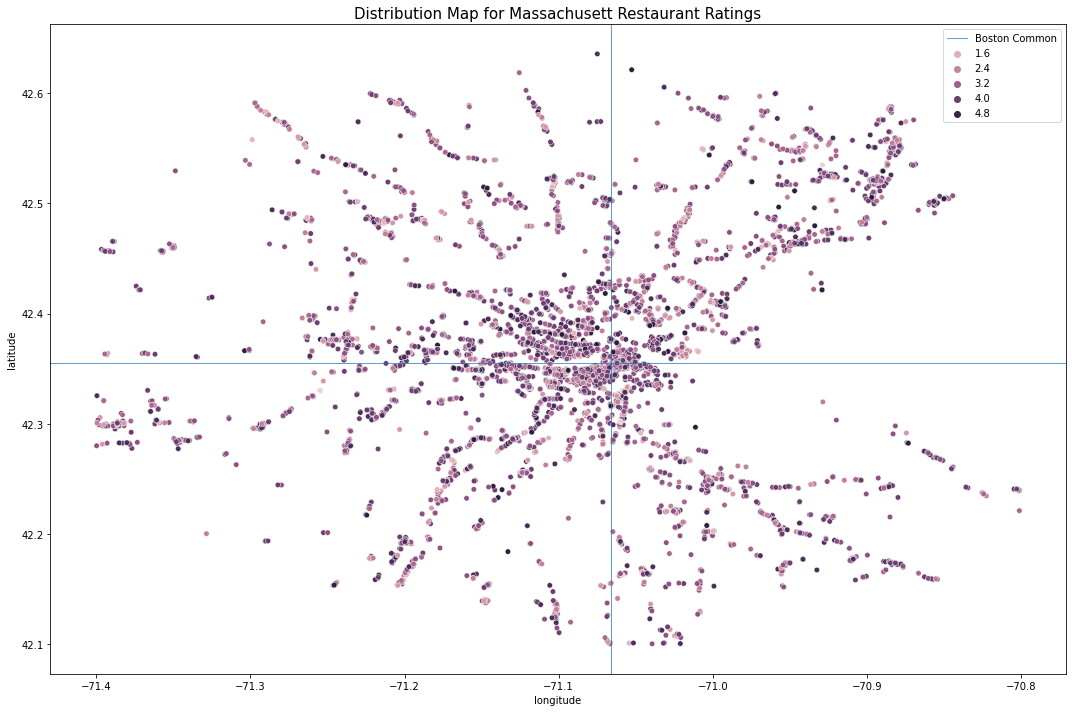

In [13]:
# Distribution of business ratings in MA on map
plt.figure(figsize=(15,10))
sns.scatterplot(x=business["longitude"], y=business["latitude"], c=business["business_stars"], s=30, hue=business["business_stars"]);
plt.title('Distribution Map for Massachusett Restaurant Ratings', fontsize=15)
plt.axhline(y=42.35528, linewidth=0.7, label='Boston Common')
plt.axvline(x=-71.06579, linewidth=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/distribution_map.png')

<Figure size 1080x1080 with 0 Axes>

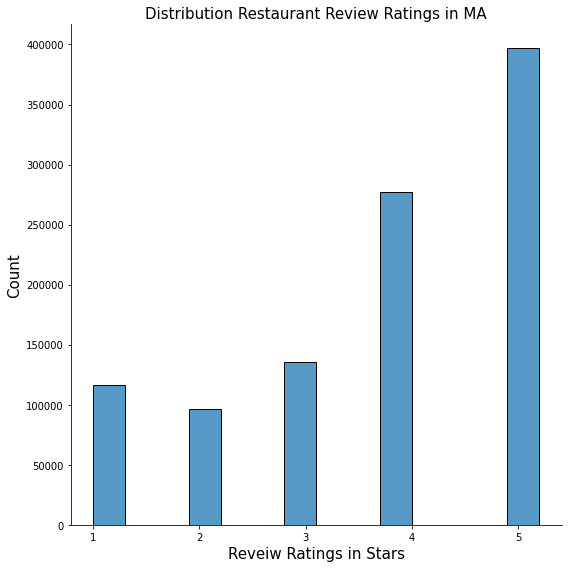

In [14]:
# Distribution of review ratings 
plt.figure(figsize=(15,15))
sns.displot(data=df['review_stars'], height = 8, binwidth=0.3)
plt.title('Distribution Restaurant Review Ratings in MA', fontsize=15)
plt.xlabel('Reveiw Ratings in Stars', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/review_ratings_displot.png')

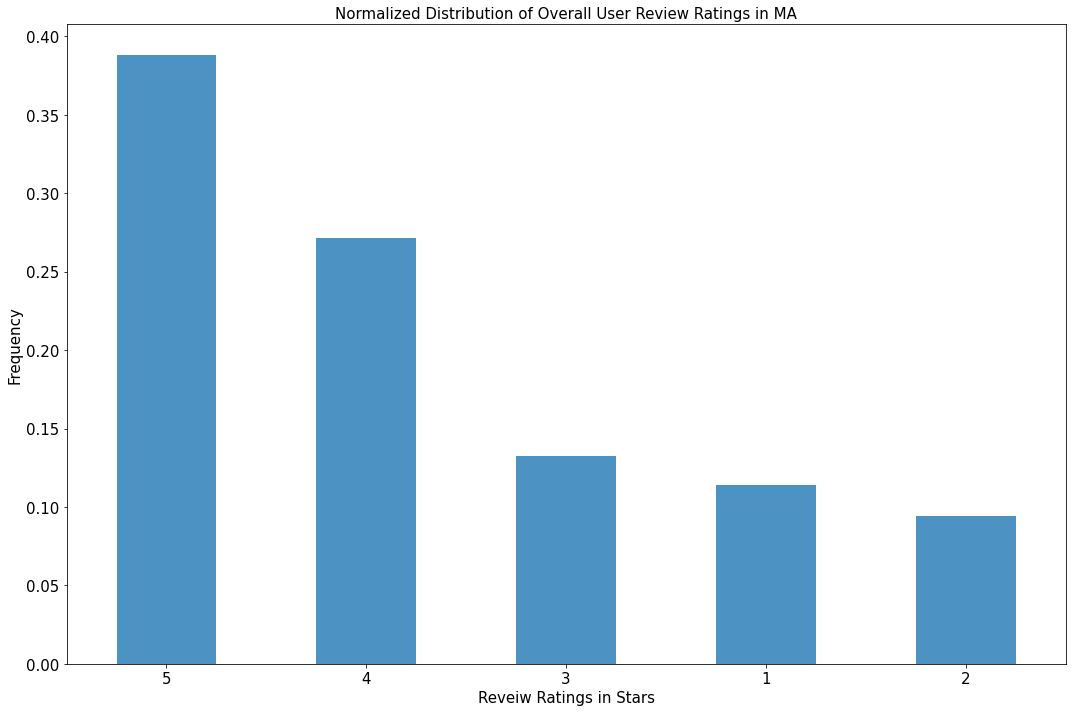

In [15]:
# Normalized distribution of overall user review ratings
plt.figure(figsize=(15,10))
(df['review_stars'].astype(int)).value_counts(normalize=True).plot(kind='bar', alpha=0.8)
plt.title('Normalized Distribution of Overall User Review Ratings in MA', fontsize=15)
plt.xlabel('Reveiw Ratings in Stars', fontsize=15)
plt.xticks(fontsize=15, rotation=360)
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/normalized_review_ratings_displot.png')

In [16]:
# Number of users who only made 1 reviews on Yelp
df_unique = df.groupby(by='user_id').count()
df_unique = df_unique.loc[df_unique['name']==1] 
list_df_unique = list(df_unique.index)
df_1_review = df.loc[df['user_id'].isin(list_df_unique)]
df_1_review.shape

(189552, 6)

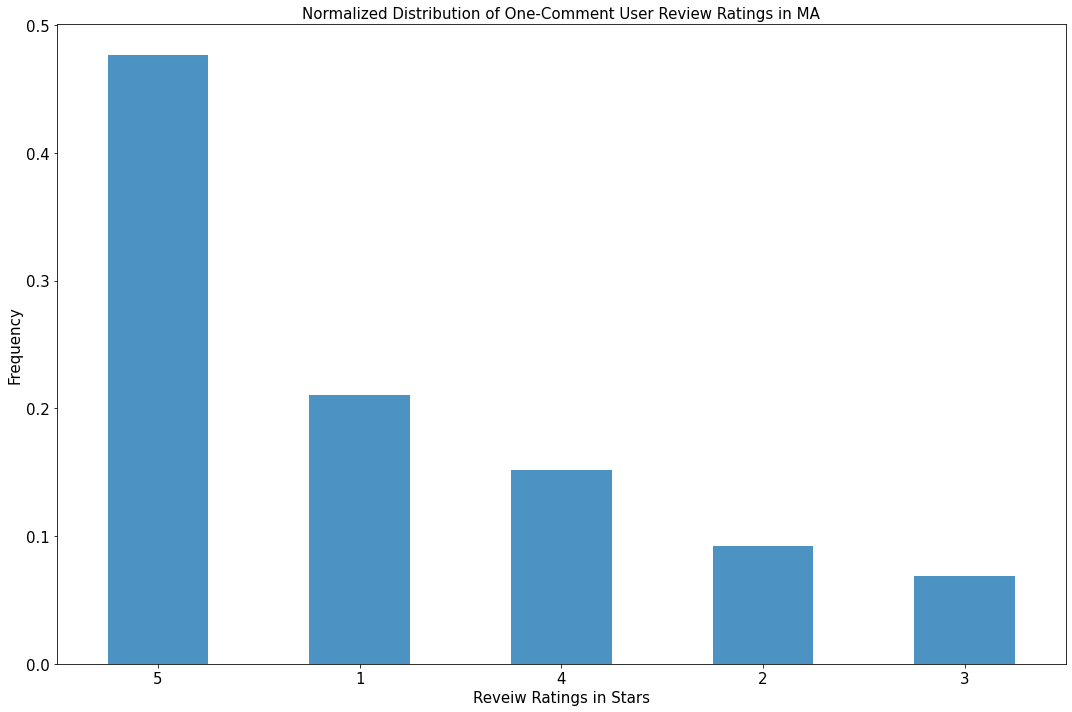

In [17]:
# Normalized distribution of one total comment user review ratings
plt.figure(figsize=(15,10))
(df_1_review['review_stars'].astype(int)).value_counts(normalize=True).plot(kind='bar', alpha=0.8)
plt.title('Normalized Distribution of One-Comment User Review Ratings in MA', fontsize=15)
plt.xlabel('Reveiw Ratings in Stars', fontsize=15)
plt.xticks(fontsize=15, rotation='horizontal')
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/normalized_1_comment_review_ratings_displot.png')

In [18]:
# Write a function to determine the number of reviews needed per user, to be more representative of the general reviewer trend
def reviewer_trend(df, range):
  trend_list = []
  for num in list(range):
    df_unique = df.groupby(by='user_id').count()
    df_unique = df_unique.loc[df_unique['name'] == num] 
    list_df_unique = list(df_unique.index)
    df_review = df.loc[df['user_id'].isin(list_df_unique)]
    trend_list.append((df_review['review_stars'].value_counts(normalize=True)))
  return trend_list

In [19]:
# Examine the rating trends of reviewers from 1 total comment to 10 total comments
reviewer_trend(df, range(1,11))

[5.0    0.476624
 1.0    0.210312
 4.0    0.152037
 2.0    0.092239
 3.0    0.068789
 Name: review_stars, dtype: float64, 5.0    0.455648
 4.0    0.208125
 1.0    0.151701
 2.0    0.093349
 3.0    0.091177
 Name: review_stars, dtype: float64, 5.0    0.442187
 4.0    0.232342
 1.0    0.127308
 3.0    0.103942
 2.0    0.094221
 Name: review_stars, dtype: float64, 5.0    0.429299
 4.0    0.252110
 1.0    0.112365
 3.0    0.111963
 2.0    0.094263
 Name: review_stars, dtype: float64, 5.0    0.420179
 4.0    0.261238
 3.0    0.120668
 1.0    0.104040
 2.0    0.093876
 Name: review_stars, dtype: float64, 5.0    0.409438
 4.0    0.269297
 3.0    0.124730
 1.0    0.101951
 2.0    0.094584
 Name: review_stars, dtype: float64, 5.0    0.402877
 4.0    0.273949
 3.0    0.126459
 2.0    0.099393
 1.0    0.097321
 Name: review_stars, dtype: float64, 5.0    0.394674
 4.0    0.283979
 3.0    0.128709
 2.0    0.096673
 1.0    0.095966
 Name: review_stars, dtype: float64, 5.0    0.375746
 4.0    0.29429

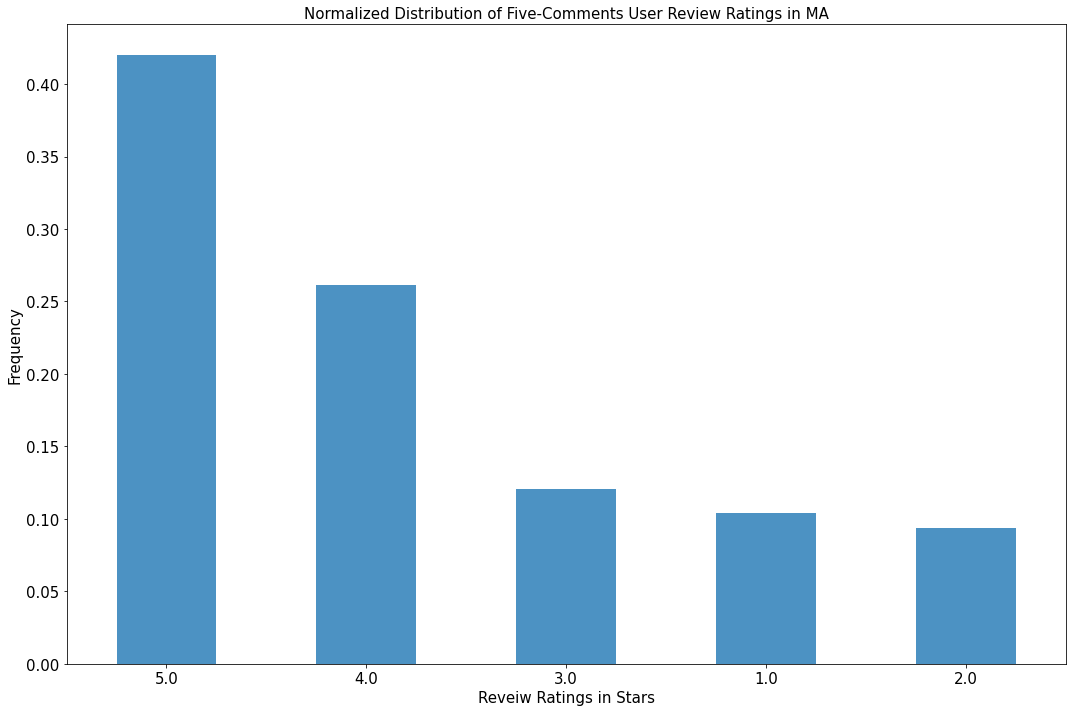

In [20]:
# Use the helper function to obtain rating trends of users who made exactly 5 comments
reviews_5_reviews = pd.DataFrame(reviewer_trend(df, range(5,6)))
# Plot the rating trend
plt.figure(figsize=(15,10))
((reviews_5_reviews).T['review_stars']).plot(kind='bar', alpha=0.8)
plt.title('Normalized Distribution of Five-Comments User Review Ratings in MA', fontsize=15)
plt.xlabel('Reveiw Ratings in Stars', fontsize=15)
plt.xticks(fontsize=15, rotation='horizontal')
plt.ylabel('Frequency', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/normalized_5_comment_review_ratings_displot.png')

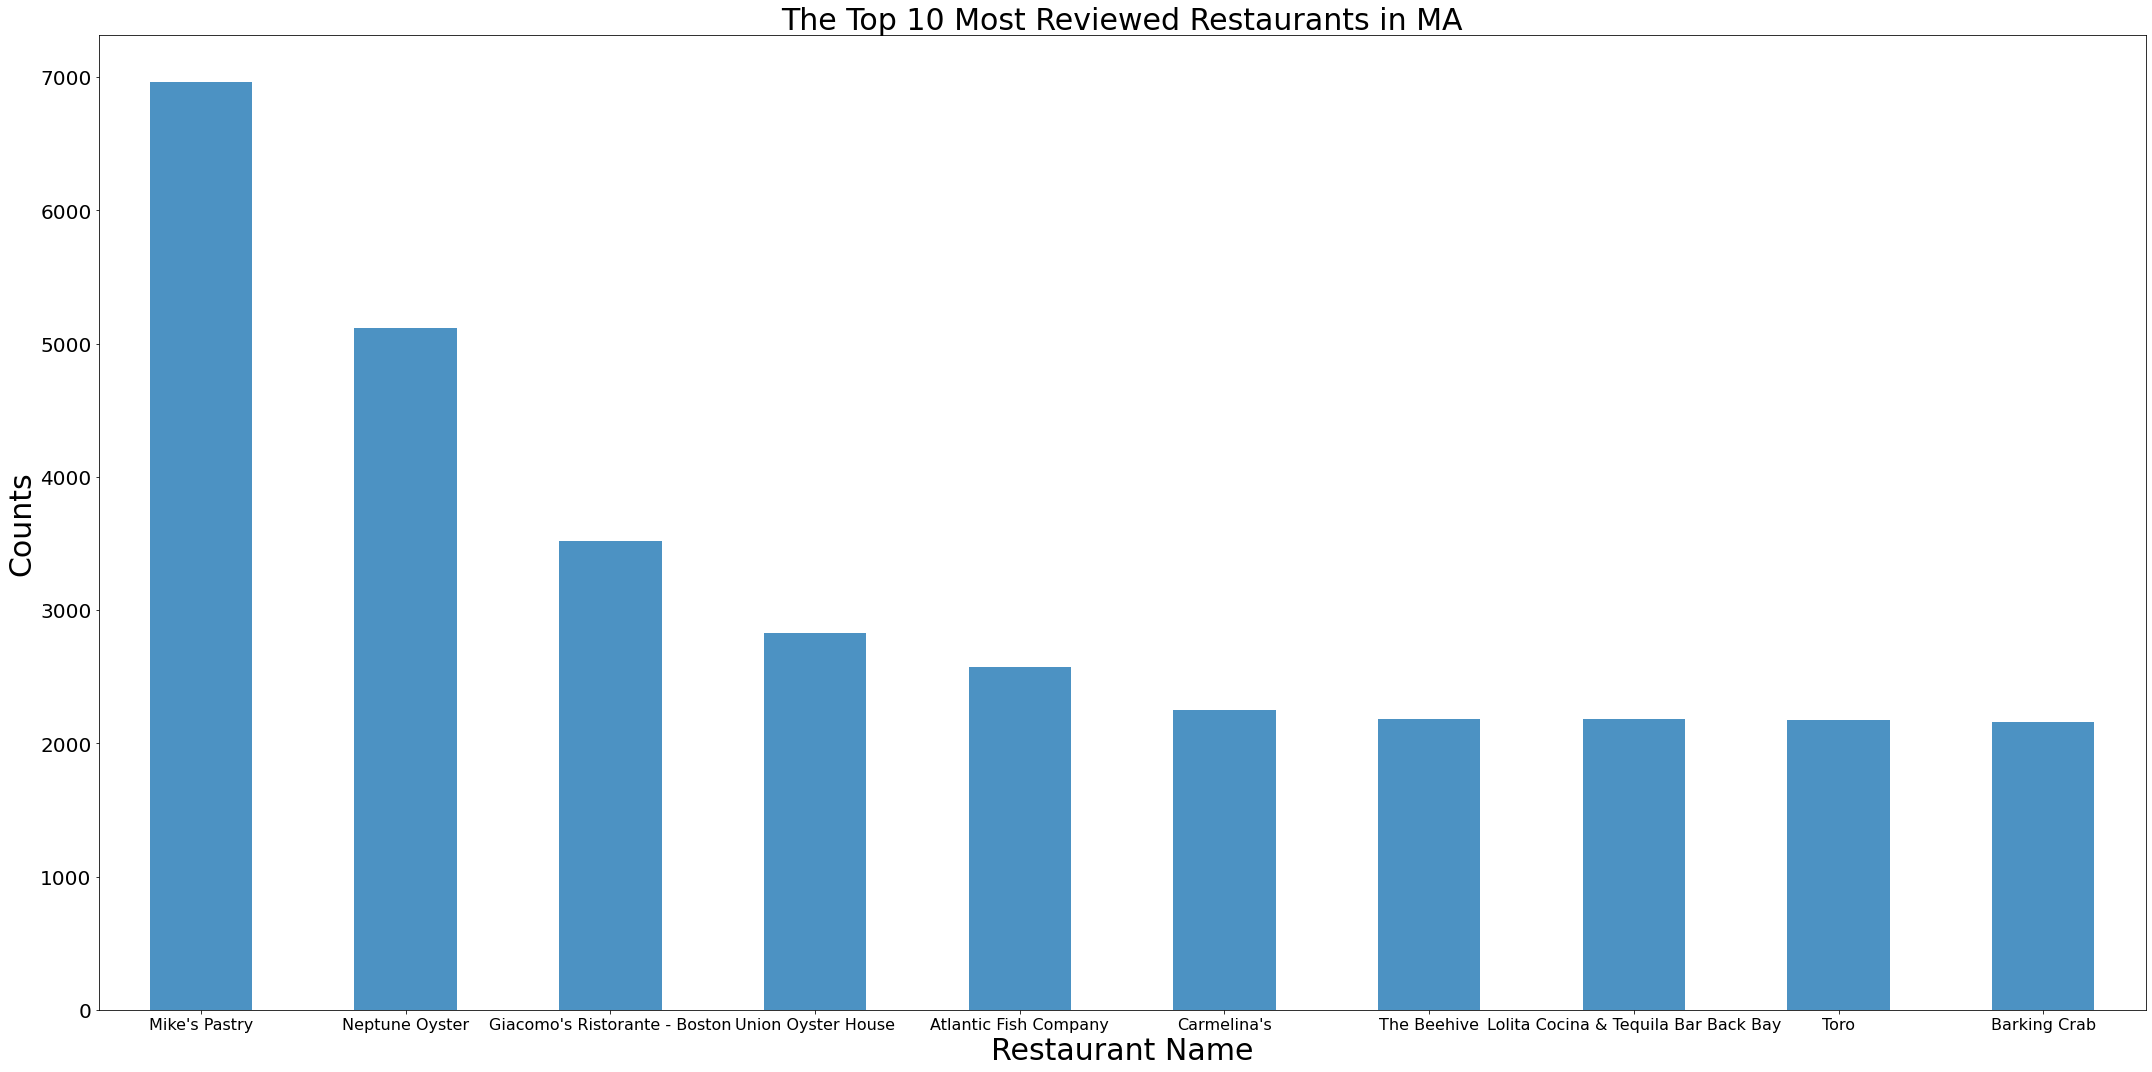

In [21]:
# Restaurant with the most number of reviews
most_popular = df.groupby(by='name').mean().sort_values(by='review_count', ascending=False).head(10)
plt.figure(figsize=(30,15))
most_popular['review_count'].plot(kind='bar', alpha=0.8)
plt.title('The Top 10 Most Reviewed Restaurants in MA', fontsize= 30)
plt.xticks(rotation='horizontal', fontsize=16)
plt.xlabel('Restaurant Name', fontsize=30)
plt.yticks(fontsize=20)
plt.ylabel('Counts', fontsize=30)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/most_reviewed_displot.png')

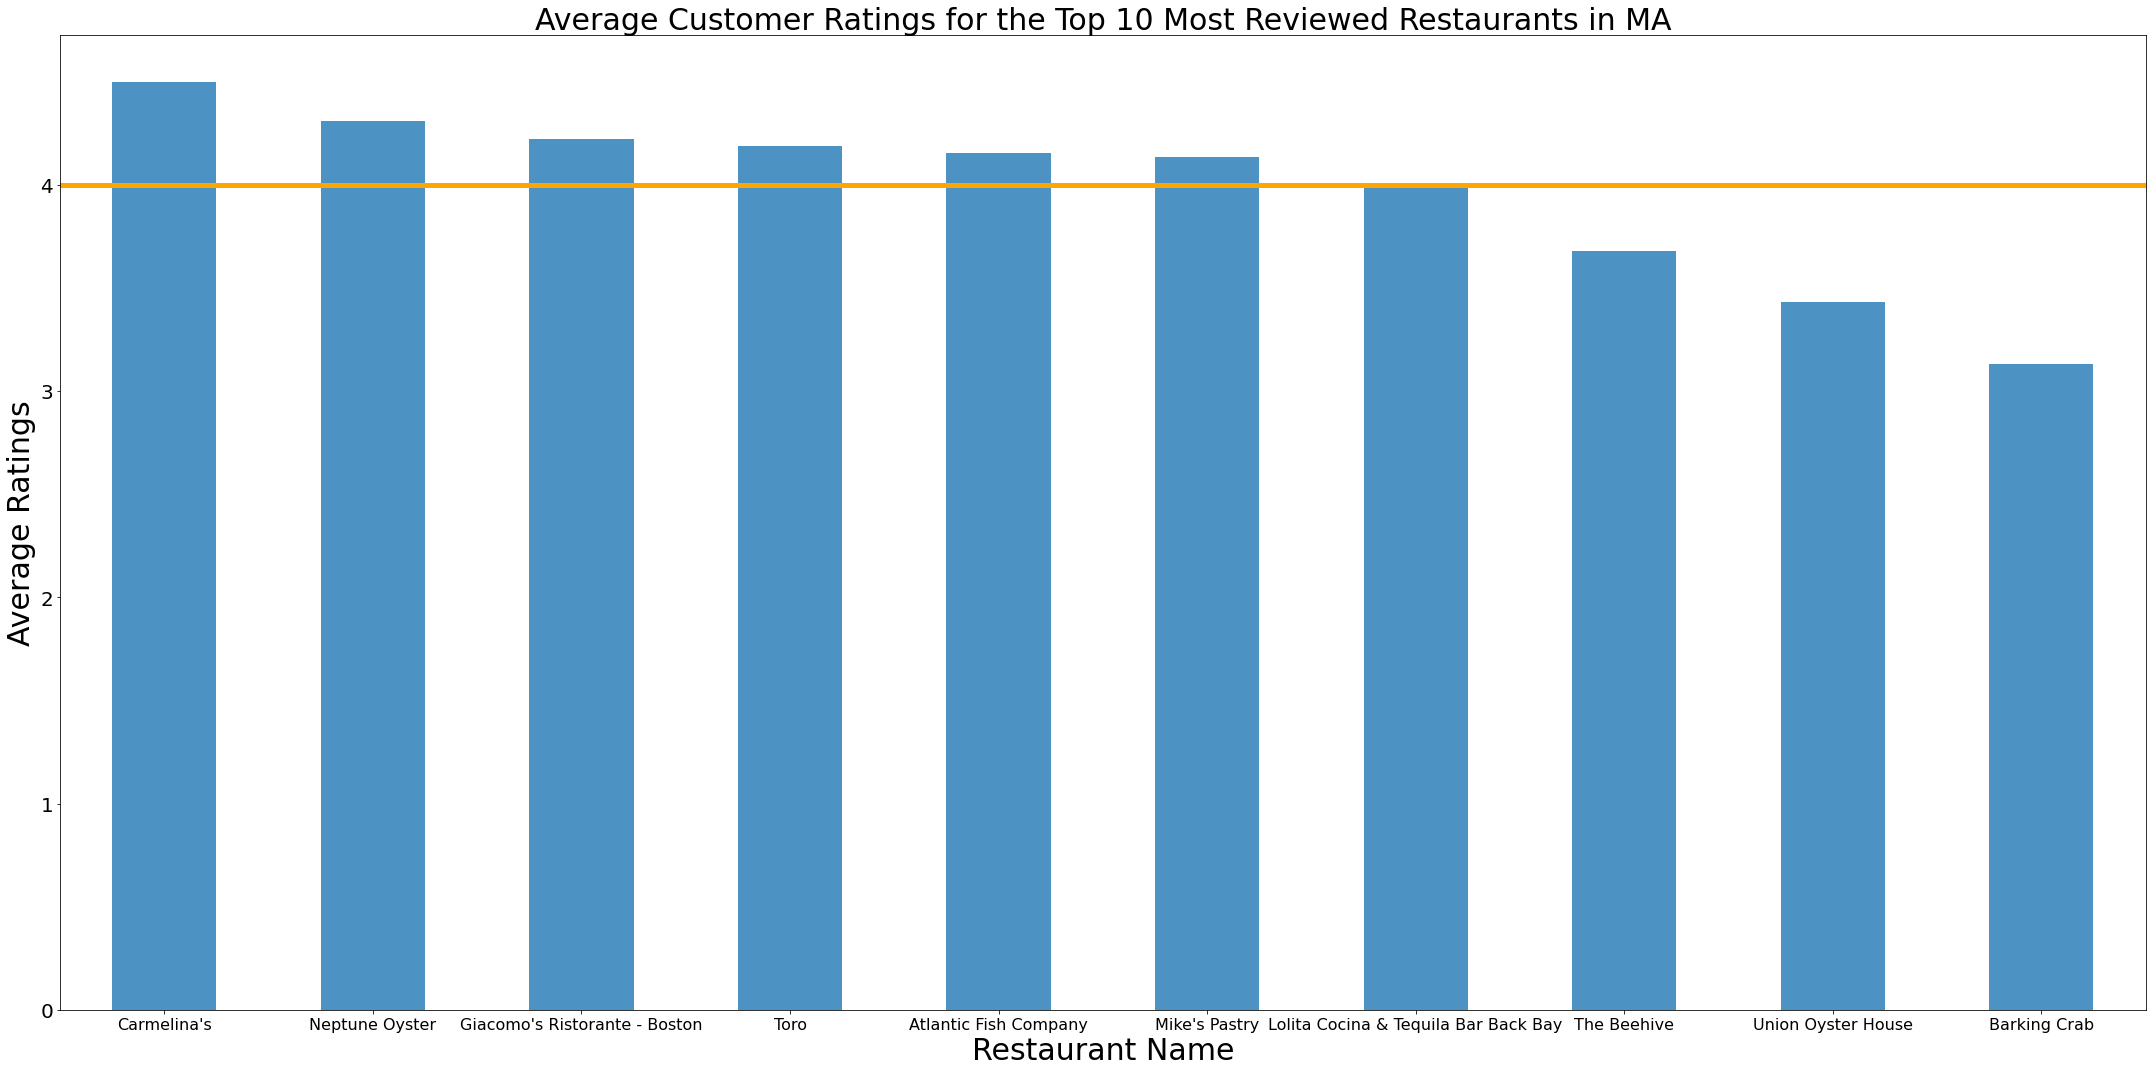

In [22]:
plt.figure(figsize=(30,15))
most_popular['review_stars'].sort_values(ascending=False).plot(kind='bar', alpha=0.8)
plt.title('Average Customer Ratings for the Top 10 Most Reviewed Restaurants in MA', fontsize=30)
plt.xticks(rotation='horizontal', fontsize=16)
plt.hlines(4, xmin=-1, xmax=10, color='orange', linewidths=5)
plt.xlabel('Restaurant Name', fontsize=30)
plt.yticks(fontsize=20)
plt.ylabel('Average Ratings', fontsize=30)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/most_reviewed_stars_displot.png')

# Modeling - Recommender System



In [23]:
df = pd.read_csv('/content/drive/MyDrive/capstone/merge_df.csv')

In [24]:
df_edited = df[['user_id', 'name', 'review_stars']]
df_edited.shape

(1022275, 3)

In [25]:
# Filter the dataset to unique users who made 5 or more reviews in total, according to EDA, their reviews are less likely to be biased
ids = df_edited.groupby(by='user_id').count() # Group by unique user ids
ids_5 = ids.loc[ids['name']>=5] # Filter for user ids that made 5 or more comments
list_ids_5 = list(ids_5.index) 
df_5_or_more = df_edited.loc[df_edited['user_id'].isin(list_ids_5)] # New dataframe with only reviewers who made more than 5 comments 
df_5_or_more.shape 

(586054, 3)

In [43]:
# Split the dataset into different portions for different and for more efficient modeling purpose
df100 = df_5_or_more
df50 = df_5_or_more.sample(frac = 0.5, random_state=88)
df20 = df_5_or_more.sample(frac = 0.2, random_state=88)

In [27]:
# Item-based collaborative filtering
pivot = pd.pivot_table(df100, index='name', columns='user_id', values='review_stars')
pivot.head()

user_id,--1ZsAsSdoqgoZZTYjsuiw,--A8rRSzpXtQ0MzgYLTv_w,--FjE9oO0KiAwTENxFfjNg,--VRlNiGyCGDzVnLLo1pZg,--YlDvlyzdBsAC0mM4YMbQ,--nGiW7kW-q2FDQE0DAngg,-0-IDTJ6A5xM4ZRYYusUCA,-03y31IzykunU9azzgLsoQ,-05Qe5nEy9twR49Q7rwuxw,-06Oh5wyl3QnNT1P9HBgnw,-08w3Q27ReI3bCu9oEsCgg,-0AyZxS5C--WySnbW_Q8yQ,-0DGavcoDjwNU70HGcfRWA,-0E7Nh2B3ftgjKv6Lh5gpA,-0F3ZaQY9rz_5ltYsMTj5w,-0di8E9u5_tfoAv5wHZhrw,-0drpO7uja55oi6CyYqPNA,-0ryDHRHIl3n6_NHvgF17g,-0suWyecW_bkCBupfIFJcg,-0uliHFpwJpYOL37Bpd1uw,-16rUUo8ZIVh0q2id7iWAQ,-1DyzG1BVvIMopoHWVZzGA,-1XjZN1IYcaGGdjTlmA3Sw,-1ZD244w5_PGPIwptksiQw,-1ZfXVMF3Mg5kogQsw4xOw,-1_AmTwFvDqSkKUyjvk6aA,-1nIHWgmuJPPmZRokOrgnw,-1qhtE22LZcmbk576XBmRg,-1yjXUKzqm9UuYtEtMTsNw,-2-PAFFzo4DTWiU4sQ5Ggw,-205Lu-l0Fqy5dAdib7coA,-22d-oD4m4zupTzRJP2qgg,-2IDTo44j2v3YhY39GnleQ,-2J7cVyVzOu2job6P37wDA,-2RNMG7dSPLX1WVJzwfCkQ,-2YSaYsU_OF_01uaNcVEog,-2i7SsuOiA_RizkPz61z4w,-2j3Ue-MqWeqJzPtV1YjDw,-2pKRtX7Kw39geAUbGt1hg,-2pgJPDJKSrQBLSTgPlvNA,...,zwix0pU-r-_AZRm9-AWkuQ,zwqF9K4I6nZz7gZtd3Iq2g,zwwuNwHpxNbfSp9Kb6W13Q,zx1tklXFIsQxK9LDgF5CPw,zx4c7K-1eBSvEmUg7zqiZQ,zx5oVCNF2v4nR8f3lo3X-g,zxBI9wOUMGq5I4jarZAZ1g,zxHi_PDwU8uQ1P9wCGmMAQ,zxTP8vN801BWZRrqReH_Zg,zxWda_PjNpCIDLdnShtzFw,zxYynrs-xaMlhcapkGUSCw,zxbSWSlwTU54k3C7GMBGvw,zxhbwI7ECrfUXMa1fOh6EQ,zxiOYzseebKj-wOUJXV8ig,zxplPLfFXIlOl8lMAv2vtg,zxy9RNkt3yU04u8n9qUiAg,zy41wmJsqvzCuUpusBBrTg,zyFtpUqG5vXYAD9ujavYdQ,zyNReO445kQhgEV49RsyUA,zyOJ1BS4Mj0_HqjWpNYzTQ,zyPPLyXWIBMkKTCgxA7H0A,zyWaRm7rJOCtaZSbcT-O5g,zyXg0HjQg7If-HiXIoW6JQ,zyYL5S9CgWqGsc8vrsSqwg,zyjRAF9N5CEcDGIipLw1HQ,zyrJYlzwdqPJSmQOy1e_ZQ,zyrypdb7ldM5yLta5XwEfQ,zyu2pAs7DxyHiq26sQfK0g,zyvxtbh5eJ86bVgk52Yflg,zz6iMj3c3tszptCjbmBVKg,zzFjqOhG4GanDQqv5bcY8A,zzI_2sZvrsywT6PIZluGxw,zzJm-M-69KHSE-Hi_ljxbA,zzLVKM8BAbyLdmcpQZi2BQ,zzPaUw6_RORmQl-09uKNGA,zzS2k_Cm1NqLcPdV0k-OAA,zzbstceqHfKskmIPu4G83g,zzdi0RIbc21HMJYIpBg8lw,zzj8cLocwSe1tZiiHddwBg,zzkggA3Ga3rN-oICULoFFQ
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
&pizza - Harvard Square,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100% Delicias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100% Delicias Express,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048 Bar and Grill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110 Grill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Create sparse matrix
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))

dists = cosine_distances(sparse_pivot)  # distance of 1 is a similarity of 0

# Get similarity, which is 1 - distance
recommender_df = pd.DataFrame(dists, columns = pivot.index, index=pivot.index)

In [29]:
# Evaluate recommener performance 
def recommend_restaurants(search):
    restaurants = pivot.filter(like = search, axis='index').index

    for name in restaurants:
        print(name)
        print('Average rating', pivot.loc[name].mean())
        print('Number of ratings', pivot.loc[name].count())
        print('')
        print('10 closest restaurants')
        print(recommender_df[name].sort_values()[1:11])
        print('')
        print('*******************************************************************************************')
        print('')
    

In [30]:
# Obtain total reviews received per restaurant chain by reviewers with at least five reviews. 
df100.groupby(by='name').count().sort_values(by=['user_id'])

,user_id,review_stars
name,,
Baba's Pizza,1,1
Elena's Cafe,1,1
Battery Wharf Grille,1,1
Seasons,1,1
Food For Thought,1,1
...,...,...
The Cheesecake Factory,1846,1846
Flour Bakery + Café,1989,1989
Neptune Oyster,1994,1994


In [31]:
# Simialr restaurant recommendations for a restaurant with 1 reviews
recommend_restaurants("Baba's Pizza")

Baba's Pizza
Average rating 3.0
Number of ratings 1

10 closest restaurants
name
Moe's Southwest Grill      0.792476
IndianStyle                0.862233
Asia Wok                   0.874459
Saffron Indian Grill       0.896165
Green Papaya               0.900396
99 Restaurants             0.951112
Royal India Bistro         0.952880
Punjabi Dhaba              0.959637
Athan's Bakery             0.987312
&pizza - Harvard Square    1.000000
Name: Baba's Pizza, dtype: float64

*******************************************************************************************



In [32]:
# Simialr restaurant recommendations for a restaurant with 1628 reviews
recommend_restaurants("The Cheesecake Factory")

The Cheesecake Factory
Average rating 3.1028460278460286
Number of ratings 1628

10 closest restaurants
name
Panera Bread                       0.853173
TGI Fridays                        0.858758
Five Guys                          0.861856
Olive Garden Italian Restaurant    0.867171
Bertucci's Italian Restaurant      0.871117
Texas Roadhouse                    0.884420
Dave & Buster's                    0.884940
P.F. Chang's                       0.885198
Chipotle Mexican Grill             0.887623
The Capital Grille                 0.890202
Name: The Cheesecake Factory, dtype: float64

*******************************************************************************************



In [33]:
# Simialr restaurant recommendations for a restaurant with 3619 reviews
recommend_restaurants("Mike's Pastry")

Mike's Pastry
Average rating 4.060698167081146
Number of ratings 3619

10 closest restaurants
name
Modern Pastry Shop               0.782920
Giacomo's Ristorante - Boston    0.806610
Neptune Oyster                   0.817108
Flour Bakery + Café              0.848353
Regina Pizzeria                  0.849679
Boston Chowda                    0.854806
Union Oyster House               0.862944
Quincy Market                    0.863544
The Daily Catch                  0.866183
Legal Sea Foods                  0.873152
Name: Mike's Pastry, dtype: float64

*******************************************************************************************



In [34]:
# User_based collaborative filtering recommender
pivot_user = pd.pivot_table(df100, index='user_id', columns='name', values='review_stars')
sparse_pivot_user = sparse.csr_matrix(pivot_user.fillna(0)) # Create sparse matrix
dists_user = cosine_distances(sparse_pivot_user) # Similarity matrix, use cosine_distances
recommender_df_user = pd.DataFrame(dists_user, columns=pivot_user.index, index=pivot_user.index)

In [35]:
def recommend_restaurants_user(search):
    restaurants = pivot_user.filter(like=search , axis='index').index

    for user_id in restaurants:
        print(user_id)
        print('Average rating', pivot_user.loc[user_id].mean())
        print('Number of ratings', pivot_user.loc[user_id].count())
        print('')
        print('10 closest users')
        print(recommender_df_user[user_id].sort_values()[1:11])
        print('')
        print('*******************************************************************************************')
        print('')

In [36]:
# Find user with minimum number of reviews, and user with maximum number of reviews
df100.groupby(by='user_id').count().sort_values(by='name')

,name,review_stars
user_id,,
FJ54rPZTJqYBaC7UeRMlrw,5,5
pIyQA5HsHg-_XJ07hvju6Q,5,5
pIgDN5WJSx3H27ESTyBHeQ,5,5
MU2exeg4ESL10tkd2A8VQg,5,5
pIbuh85hbMNKNMvIwVNLrQ,5,5
...,...,...
5kMii2JySygayQpyPBjqCA,371,371
1Y0zsJSfWLkfDylH0X1yNQ,425,425
ggl6fl-PM5O1WrdReL0l4A,472,472


In [37]:
# Simialr user recommendations for users who made 5 total reviews
recommend_restaurants_user("pIyQA5HsHg-_XJ07hvju6Q")

pIyQA5HsHg-_XJ07hvju6Q
Average rating 4.4
Number of ratings 5

10 closest users
user_id
7G3aPclKS14hYcyi1UZmSg    0.544777
6Yworw3wCXcUewDFEtqbsA    0.561471
wW_y1iJWiEMKISRnRS6JHQ    0.649321
KQIRAraxB98jegoGejfZqA    0.656728
ulySjSR_mlYnHBMDwBHoyw    0.663267
aLP9za6SsG-pDkGl32Oq-g    0.693030
1eLYK0WfkGqJQ1Pacqi6gg    0.702718
Id5iBlKYnQDl5sk6fpEeNg    0.709066
GRIGHT1GynVFUGy8F2hMYQ    0.710971
SYrsS0IkSUAEs4aQTiK4zg    0.719776
Name: pIyQA5HsHg-_XJ07hvju6Q, dtype: float64

*******************************************************************************************



In [38]:
# Simialr user recommendations for users who made 440 total reviews
recommend_restaurants_user("rcU7ysY41qGppbw4pQgjqg")

rcU7ysY41qGppbw4pQgjqg
Average rating 3.828787878787879
Number of ratings 440

10 closest users
user_id
wCtf5_zG8EpWiBp_Oi7P0g    0.712774
8rNzNxp054ydMQ19v6iAYA    0.731495
s1Hsu9cFf5qJym5-ujO2MQ    0.734564
1Y0zsJSfWLkfDylH0X1yNQ    0.740793
t903_es-gp3abvdrIQutQA    0.742533
ggl6fl-PM5O1WrdReL0l4A    0.746618
ir689oBNmrJXOspb4yq_Jg    0.757240
_NTm9Xv0gDfafBQxR3uUyQ    0.758394
DICLJDdq0HpvOVYR5mB4gA    0.762235
8cvp_IjFGoGPq5RU51KRAg    0.767355
Name: rcU7ysY41qGppbw4pQgjqg, dtype: float64

*******************************************************************************************



In [39]:
# Simialr user recommendations for users who made 613 total reviews
recommend_restaurants_user("nl8gWLDo6U6MjqzbBmE_9A")

nl8gWLDo6U6MjqzbBmE_9A
Average rating 3.5101633910769308
Number of ratings 613

10 closest users
user_id
8cvp_IjFGoGPq5RU51KRAg    0.709657
DICLJDdq0HpvOVYR5mB4gA    0.732197
ggl6fl-PM5O1WrdReL0l4A    0.736282
q0qfXy1rflTmr9Q7IfVCeA    0.737962
T3k8yd4k66U2BtaebW05lw    0.742331
DeqIeM5LTAC4MmYLtJxn7Q    0.744118
GN83yGu-5Isw5iVJ5cFj9w    0.747535
CvEJxu4gfEeG2FPaJKkD3w    0.748091
hWDybu_KvYLSdEFzGrniTw    0.750847
7J6sOvhSksLtzO9hFPEnGQ    0.753879
Name: nl8gWLDo6U6MjqzbBmE_9A, dtype: float64

*******************************************************************************************



In [44]:
# Collaborative Filtering with Surprise recommender system
# Transform pandas dataframes into raw_ratings
reader = Reader(rating_scale=(1,5))
data100 = Dataset.load_from_df(df100, reader) # The full dataset. 
data = Dataset.load_from_df(df50, reader) # 50% of the dataset. For faster cross_validation purpose. 
data20 = Dataset.load_from_df(df20,reader) # 20% of the dataset. Certain models, such as KNN requires much more RAM space to run, smaller dataset is more efficient

In [45]:
# Automatic cross_validation on multiple algorithms
# SVD 
cross_validate(SVD(), data, measures=['RMSE','MAE'], cv=3, verbose=True)

# SVDpp - The SVD++ algorithm, an extension of SVD taking into account implicit ratings.
cross_validate(SVDpp(), data, measures=['RMSE','MAE'], cv=3, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1249  1.1273  1.1272  1.1265  0.0011  
MAE (testset)     0.8970  0.8976  0.8974  0.8973  0.0002  
Fit time          12.91   23.28   18.73   18.31   4.25    
Test time         1.40    4.05    1.19    2.21    1.30    
Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1284  1.1304  1.1313  1.1300  0.0012  
MAE (testset)     0.8978  0.8962  0.8973  0.8971  0.0007  
Fit time          54.90   53.87   54.37   54.38   0.42    
Test time         3.99    5.05    4.16    4.40    0.47    


{'fit_time': (54.9036169052124, 53.867186546325684, 54.3690128326416),
 'test_mae': array([0.89779102, 0.89615802, 0.89732862]),
 'test_rmse': array([1.12838619, 1.13039804, 1.13128305]),
 'test_time': (3.985365629196167, 5.0486977100372314, 4.160780429840088)}

In [46]:
# KNNBasic - A basic collaborative filtering algorithm.
cross_validate(KNNBasic(), data20, measures=['RMSE','MAE'], cv=3, verbose=True)

# KnnWithMeans - A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
cross_validate(KNNWithMeans(), data20, measures=['RMSE','MAE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2847  1.2830  1.2820  1.2832  0.0011  
MAE (testset)     1.0201  1.0203  1.0188  1.0197  0.0007  
Fit time          66.06   54.06   40.55   53.56   10.42   
Test time         2.95    2.71    2.92    2.86    0.11    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3557  1.3664  1.3678  1.3633  0.0054  
MAE (testset)     1.0249  1

{'fit_time': (43.40480375289917, 49.85342597961426, 54.76908564567566),
 'test_mae': array([1.02491377, 1.038074  , 1.0353327 ]),
 'test_rmse': array([1.35567803, 1.36637159, 1.3678412 ]),
 'test_time': (2.750375270843506, 2.828646659851074, 2.7220497131347656)}

In [47]:
# Automatic cross_validation on multiple algorithms
# NMF - A collaborative filtering algorithm based on Non-negative Matrix Factorization.
cross_validate(NMF(), data, measures=['RMSE','MAE'], cv=3, verbose=True)

# SlopeOne - A simple yet accurate collaborative filtering algorithm.
cross_validate(SlopeOne(), data, measures=['RMSE','MAE'], cv=3, verbose=True)

# CoClustering - A collaborative filtering algorithm based on co-clustering.
cross_validate(CoClustering(), data, measures=['RMSE','MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3058  1.3042  1.3030  1.3043  0.0012  
MAE (testset)     1.0156  1.0145  1.0147  1.0149  0.0005  
Fit time          19.10   19.45   19.24   19.26   0.15    
Test time         1.34    1.06    1.05    1.15    0.13    
Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3263  1.3211  1.3213  1.3229  0.0024  
MAE (testset)     0.9957  0.9932  0.9929  0.9939  0.0013  
Fit time          1.87    1.96    1.88    1.90    0.04    
Test time         2.65    2.70    2.78    2.71    0.06    
Evaluating RMSE, MAE of algorithm CoClustering on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.2391  1.2410  1.2382  1.2394  0.0011  
MAE (testset)     0.9351  0.9358  0.9349  0.9353  0.0004  
Fit time          11.00   10.31   10.88   10.73   0.30   

{'fit_time': (11.003817558288574, 10.311588048934937, 10.876979351043701),
 'test_mae': array([0.93511807, 0.93579757, 0.93494306]),
 'test_rmse': array([1.23911815, 1.24096504, 1.23822328]),
 'test_time': (1.159761905670166, 1.1536951065063477, 1.154484510421753)}

In [49]:
# Split the full dataset into Train and Test sets, with 30% testsize
trainset, testset = train_test_split(data100, test_size=.3, random_state=88)

In [50]:
# Instanitiate svd model
svd = SVD()
# Fit on the trainset
svd= svd.fit(trainset)
# Make prediction on testset
predictions = svd.test(testset)

In [51]:
# Evaluate the  rmse for svd model
print(accuracy.rmse(predictions))

# Evaluate the mae for svd model
print(accuracy.mae(predictions))

RMSE: 1.1107
1.110687897644354
MAE:  0.8785
0.8785051692798806


In [52]:
# GridSearch for lower rmse model
param_grid = {
      'n_epochs': [20, 50], 'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4] }
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

In [53]:
# best RMSE score
print(gs.best_score['rmse'], gs.best_score['mae'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'], gs.best_params['mae'])

1.1164857009716067 0.8866207480106941
{'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.2} {'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.2}


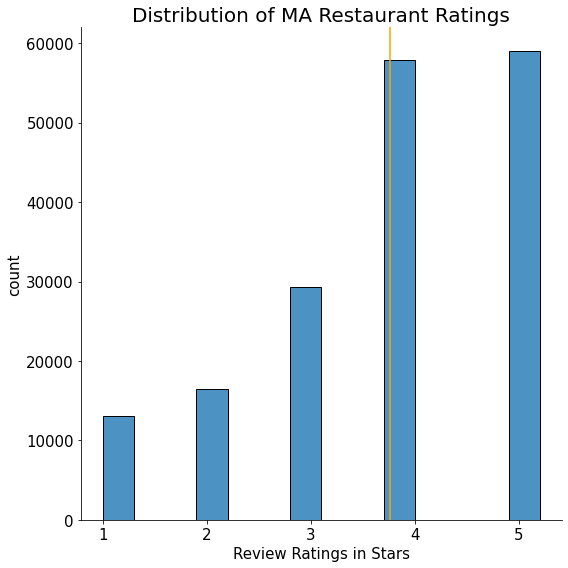

In [54]:
# Plot prediction vs actual ratings
predictions = pd.DataFrame(predictions)
sns.displot(predictions['r_ui'], height=8, binwidth=0.3, alpha=0.8)
plt.axvline(x=predictions['r_ui'].mean(), color='orange')
plt.title('Distribution of MA Restaurant Ratings', fontsize=20)
plt.xlabel('Review Ratings in Stars', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('count', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/actual_displot.png')

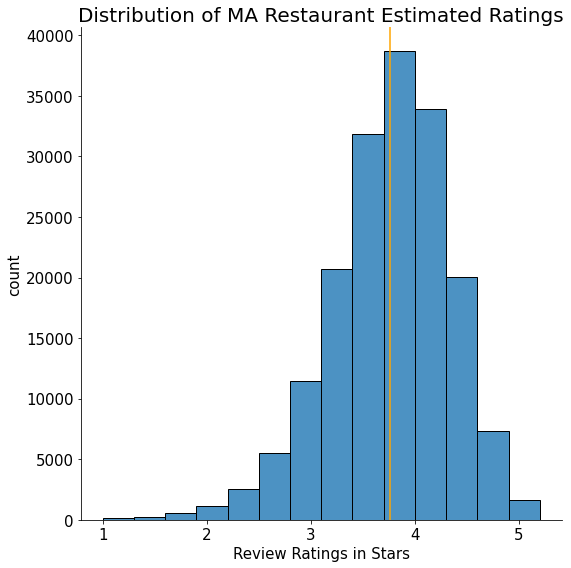

In [55]:
# Plot the estimated ratings 
sns.displot(predictions['est'], height = 8, binwidth=0.3, alpha=0.8)
plt.axvline(x=predictions['est'].mean(), color='orange')
plt.title('Distribution of MA Restaurant Estimated Ratings', fontsize=20)
plt.xlabel('Review Ratings in Stars', fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('count', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/capstone/figures/prediction_displot.png')

In [56]:
predictions.rename(columns={'uid': 'user_id', 'iid': 'name', 'r_ui': 'actual_rating', 'est': 'est_rating'}, inplace=True)
predictions.head()

,user_id,name,actual_rating,est_rating,details
0,JXLB1eBAsNO_HkcRADsV1Q,Double Chin,3.0,3.840020,{'was_impossible': False}
1,xKZtmgY9WMmaFG0wQz59YA,Ula Café,5.0,4.006857,{'was_impossible': False}
2,T_srLp4IZWWXAf3CN7uz8w,The Capital Grille,5.0,4.114048,{'was_impossible': False}
3,QLw0HHXMkZZaXUE-pOIdtg,Regina Pizzeria,5.0,3.539650,{'was_impossible': False}
4,_zy15R11eiKiLBmuVqc49g,SORA,2.0,3.172284,{'was_impossible': False}


In [58]:
# Put the svd model to function
def rating_estimation(user_id, name):
  return print(f" You are likely to rate this place {np.round(svd.predict(str(user_id), str(name))[3], 1)} stars")

In [72]:
# Test the recommender system on user who made 613 reviews total
rating_estimation('pIyQA5HsHg-_XJ07hvju6Q', "McDonal's"), 
rating_estimation('7G3aPclKS14hYcyi1UZmSg', "McDonal's"),
rating_estimation('6Yworw3wCXcUewDFEtqbsA', "McDonal's")

 You are likely to rate this place 3.9 stars
 You are likely to rate this place 3.8 stars
 You are likely to rate this place 3.9 stars


In [73]:
rating_estimation('pIyQA5HsHg-_XJ07hvju6Q', "McDonal's"), 
rating_estimation('GRIGHT1GynVFUGy8F2hMYQ', "McDonal's"),
rating_estimation('SYrsS0IkSUAEs4aQTiK4zg', "McDonal's")

 You are likely to rate this place 3.9 stars
 You are likely to rate this place 4.1 stars
 You are likely to rate this place 4.1 stars


In [74]:
# Test the recommender system on user who made 5 reviews total
rating_estimation('nl8gWLDo6U6MjqzbBmE_9A', "McDonal's"), 
rating_estimation('hWDybu_KvYLSdEFzGrniTw', "McDonal's"),
rating_estimation('7J6sOvhSksLtzO9hFPEnGQ', "McDonal's")

 You are likely to rate this place 3.4 stars
 You are likely to rate this place 4.1 stars
 You are likely to rate this place 3.3 stars


In [71]:
rating_estimation('nl8gWLDo6U6MjqzbBmE_9A', "McDonal's"), 
rating_estimation('8cvp_IjFGoGPq5RU51KRAg', "McDonal's"),
rating_estimation('DICLJDdq0HpvOVYR5mB4gA', "McDonal's") 

 You are likely to rate this place 3.4 stars
 You are likely to rate this place 3.3 stars
 You are likely to rate this place 3.5 stars
